# Setup

In [1]:
import torch
import numpy as np

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

from IPython.display import clear_output

# Defining, training, and plotting features of a toy model

In [10]:
from sae_lens.training.toy_models import ToyConfig, ReluOutputModel

cfg = ToyConfig(
    n_instances=1,
    n_features=5,
    n_hidden = 2,
    feature_probability = 0.1,
    device=device
)
model = ReluOutputModel(cfg)
model.optimize()

Training Toy Model: 100%|██████████| 10000/10000 [00:02<00:00, 3617.91it/s, loss=0.00478, lr=0.001]


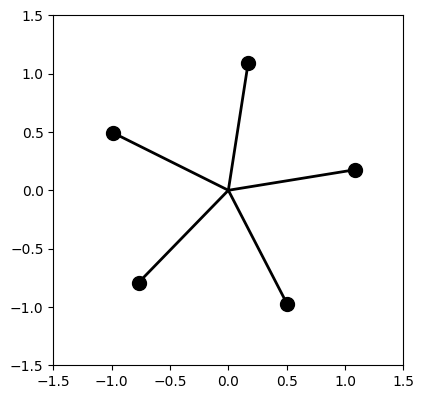

In [11]:
from sae_lens.training.toy_models import plot_features_in_2d

plot_features_in_2d(values=model.W)

In [12]:
# note that the model is built on HookedRootModule, so can be run_with_cache.
batch = model.generate_batch(10)
output, cache = model.run_with_cache(batch)
print(cache.keys())

dict_keys(['hook_hidden', 'hook_out_prebias'])


# Make an activation store for toy models

# Training an SAE on the toy model

In [13]:
from sae_lens.training.config import LanguageModelSAERunnerConfig
from sae_lens.training.sae_group import SparseAutoencoderDictionary
from sae_lens.training.activations_store import ToyActivationsStore

sae_cfg = LanguageModelSAERunnerConfig(
    model_name="5-in-2-toy",
    hook_point='hook_hidden',
    hook_point_eval='hook_hidden',
    dtype = torch.float32,
    cached_activations_path=None,
    d_in=cfg.n_hidden,
    log_to_wandb=False,
    context_size=1,
    store_batch_size = 1024,
    n_batches_in_buffer= 100000,
    training_tokens=2_000_000,
    l1_coefficient=0.3,
    lr=1e-3,
    expansion_factor=[4,],
    use_ghost_grads=True,
    dead_feature_window=1000,
)

store = ToyActivationsStore.from_config(model, sae_cfg)
# sae = SparseAutoencoder(sae_cfg)
# sae = train_sae_on_language_model(sae, model, store)#, n_epochs=1000)

sae_group = SparseAutoencoderDictionary(sae_cfg)


clear_output()

Run name: None-L1-0.3-LR-0.001-Tokens-2.000e+06
n_tokens_per_buffer (millions): 102.4
Lower bound: n_contexts_per_buffer (millions): 102.4
Total training steps: 488
Total wandb updates: 48
n_tokens_per_feature_sampling_window (millions): 8.192
n_tokens_per_dead_feature_window (millions): 4.096
We will reset the sparsity calculation 0 times.
Number tokens in sparsity calculation window: 8.19e+06
Using Ghost Grads.
model kwargs {}
Run name: 8-L1-0.3-LR-0.001-Tokens-2.000e+06
n_tokens_per_buffer (millions): 102.4
Lower bound: n_contexts_per_buffer (millions): 102.4
Total training steps: 488
Total wandb updates: 48
n_tokens_per_feature_sampling_window (millions): 8.192
n_tokens_per_dead_feature_window (millions): 4.096
We will reset the sparsity calculation 0 times.
Number tokens in sparsity calculation window: 8.19e+06
Using Ghost Grads.
Run name: 8-L1-0.3-LR-0.001-Tokens-2.000e+06
n_tokens_per_buffer (millions): 102.4
Lower bound: n_contexts_per_buffer (millions): 102.4
Total training st

In [14]:
from sae_lens.training.train_sae_on_language_model import train_sae_group_on_language_model

train_sae_group_on_language_model(model, sae_group, store)

model kwargs {}


Objective value: 12302208.0000:   2%|▏         | 2/100 [00:01<01:24,  1.16it/s]
1954| MSE Loss 0.024 | L1 0.040: : 2000896it [00:27, 72823.16it/s]                            

model kwargs {}


5-in-2-toy_hook_hidden_8_expansion_factor_4 SparseAutoencoder(
  (activation_fn): ReLU()
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
)


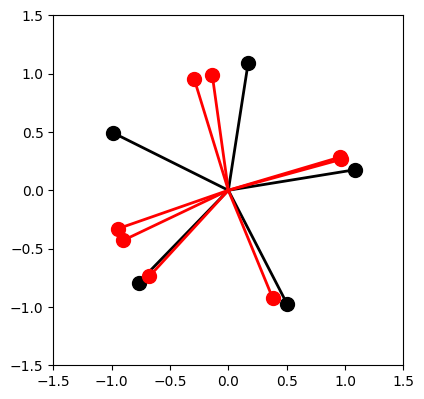

In [15]:
for name, sae in sae_group.autoencoders.items():
    print(name, sae)
    vecs = torch.cat((model.W, sae.W_dec.T[None,:]), dim=-1)
    plot_features_in_2d(values=vecs, colors=['k']*cfg.n_features+['r']*sae.cfg.d_sae)

In [16]:
from sae_lens.training.evals import run_evals

for name, sae in sae_group.autoencoders.items():
    evals = run_evals(sae, store, model, n_training_steps=0)
    print(name, evals)

5-in-2-toy_hook_hidden_8_expansion_factor_4 {'metrics/l2_norm': 0.1273452788591385, 'metrics/l2_ratio': 0.1772206425666809, 'metrics/CE_loss_score': 0.5783110737800599, 'metrics/ce_loss_without_sae': 0.005260930536314845, 'metrics/ce_loss_with_sae': 0.01676539536565542, 'metrics/ce_loss_with_ablation': 0.03257497530430555}


# Simple lm runner

In [9]:
from sae_lens.training.lm_runner import toy_model_sae_runner

model, sae_group = toy_model_sae_runner(sae_cfg, cfg)

Training Toy Model: 100%|██████████| 10000/10000 [00:02<00:00, 3744.90it/s, loss=0.00797, lr=0.001]


Run name: 8-L1-0.3-LR-0.001-Tokens-2.000e+06
n_tokens_per_buffer (millions): 102.4
Lower bound: n_contexts_per_buffer (millions): 102.4
Total training steps: 488
Total wandb updates: 48
n_tokens_per_feature_sampling_window (millions): 8.192
n_tokens_per_dead_feature_window (millions): 4.096
We will reset the sparsity calculation 0 times.
Number tokens in sparsity calculation window: 8.19e+06
Using Ghost Grads.
Run name: 8-L1-0.3-LR-0.001-Tokens-2.000e+06
n_tokens_per_buffer (millions): 102.4
Lower bound: n_contexts_per_buffer (millions): 102.4
Total training steps: 488
Total wandb updates: 48
n_tokens_per_feature_sampling_window (millions): 8.192
n_tokens_per_dead_feature_window (millions): 4.096
We will reset the sparsity calculation 0 times.
Number tokens in sparsity calculation window: 8.19e+06
Using Ghost Grads.


Training SAE:   0%|          | 0/2000000 [00:00<?, ?it/s]/Users/evananders/anaconda3/envs/ai/lib/python3.12/site-packages/einops/einops.py:827: SyntaxWarning: invalid escape sequence '\s'
  """


KeyboardInterrupt: 

['__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_init_autoencoders', 'autoencoders', 'cfg', 'eval', 'get_name', 'load_from_pretrained', 'load_from_pretrained_legacy', 'save_saes', 'to', 'train']
5-in-2-toy_hook_hidden_8_expansion_factor_4 SparseAutoencoder(
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
)
5-in-2-toy_hook_hidden_10_expansion_factor_5 SparseAutoencoder(
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
)


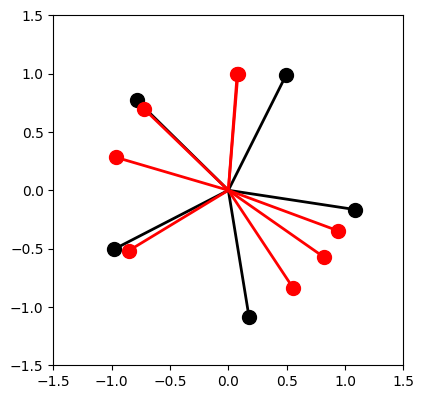

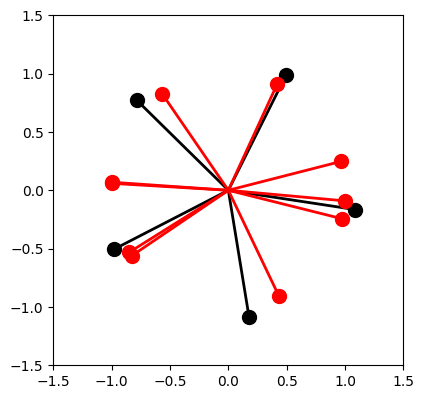

In [ ]:
print(dir(sae_group))
for name, sae in sae_group.autoencoders.items():
    print(name, sae)
    vecs = torch.cat((model.W, sae.W_dec.T[None,:]), dim=-1)
    plot_features_in_2d(values=vecs, colors=['k']*cfg.n_features+['r']*sae.cfg.d_sae)